<a href="https://colab.research.google.com/github/pNTubil/CALC-LD/blob/main/XLMR_LARGE_NICE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
##################################
# Install Necessary Libraries
##################################
!pip install transformers datasets torch scikit-learn

##################################
# Necessary Imports
##################################
import pandas as pd
import torch
from torch.utils.data import Dataset
from transformers import (
    XLMRobertaTokenizer,
    XLMRobertaForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.metrics import precision_recall_fscore_support
import os

##################################
# Disable W&B Logging
##################################
os.environ["WANDB_DISABLED"] = "true"  # Prevents W&B from asking for API key

##################################
# Dynamically Set Device (GPU if available)
##################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

##################################
# Load Preprocessed Train & Validation Dataset
##################################
train_df = pd.read_csv("/content/train_preprocessed10knew.csv")
val_df = pd.read_csv("/content/val_preprocessed10knew.csv")

##################################
# Load XLM-R Large Tokenizer
##################################
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-large')

##################################
# Define Custom Dataset Class
##################################
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts.tolist()
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        encodings = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encodings['input_ids'].squeeze().to(torch.long),
            'attention_mask': encodings['attention_mask'].squeeze().to(torch.long),
            'labels': torch.tensor(label, dtype=torch.long)
        }

##################################
# Create Train & Validation Dataset
##################################
train_dataset = ReviewDataset(train_df['review'], train_df['label'], tokenizer)
val_dataset = ReviewDataset(val_df['review'], val_df['label'], tokenizer)

##################################
# Load Pretrained XLM-R Large Model
##################################
model = XLMRobertaForSequenceClassification.from_pretrained(
    'xlm-roberta-large',
    num_labels=2  # Binary classification (Ambiguous vs. Not Ambiguous)
)
model.to(device)  # Move model to GPU if available

##################################
# Define Evaluation Metrics (Only Precision & F1)
##################################
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=1)
    precision, _, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )
    return {"precision": precision, "f1": f1}

##################################
# Training Arguments Configuration (GPU-Friendly)
##################################
training_args = TrainingArguments(
    output_dir="./xlm-r_large_results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs_xlmr_large",
    logging_steps=50,
    per_device_train_batch_size=8,  # ✅ Increased batch size for stability
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    learning_rate=2e-5,  # ✅ Lowered learning rate for stability
    weight_decay=0.01,
    fp16=True,
    gradient_accumulation_steps=2,  # ✅ Helps prevent sudden loss spikes
    max_grad_norm=1.0,  # ✅ Prevents exploding gradients
    load_best_model_at_end=True,
    save_total_limit=1,
    report_to="none",
    lr_scheduler_type="linear",  # ✅ More stable than cosine with restarts
    warmup_ratio=0.1,  # ✅ Shorter warmup period for better convergence
    metric_for_best_model="f1",
    greater_is_better=True,
    logging_first_step=True,
    eval_accumulation_steps=5
)

##################################
# Initialize Trainer
##################################
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics  # Only computes Precision & F1-score
)

##################################
# Train the Model (Using GPU if available)
##################################
trainer.train()

##################################
# Save the Best Model
##################################
trainer.save_model("./xlm-r_large_results/best_model")
print("✅ Training complete. Best XLM-R model saved to './xlm-r_large_results/best_model'")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,F1
1,0.301500,0.573641,0.887681,0.878857
2,0.175700,0.111240,0.978892,0.978446
3,0.078900,0.095651,0.977654,0.977654
4,0.060100,0.051175,0.990468,0.990423
5,0.037100,0.048651,0.991372,0.991220
6,0.019000,0.054995,0.992039,0.992019
7,0.019100,0.079935,0.989686,0.989625
8,0.000200,0.071004,0.991372,0.991220
9,0.000000,0.056321,0.992919,0.992817
10,0.000100,0.052084,0.993696,0.993615


✅ Training complete. Best XLM-R model saved to './xlm-r_large_results/best_model'


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Precision: 0.9984
F1-Score: 0.9952
ROC-AUC: 0.9989


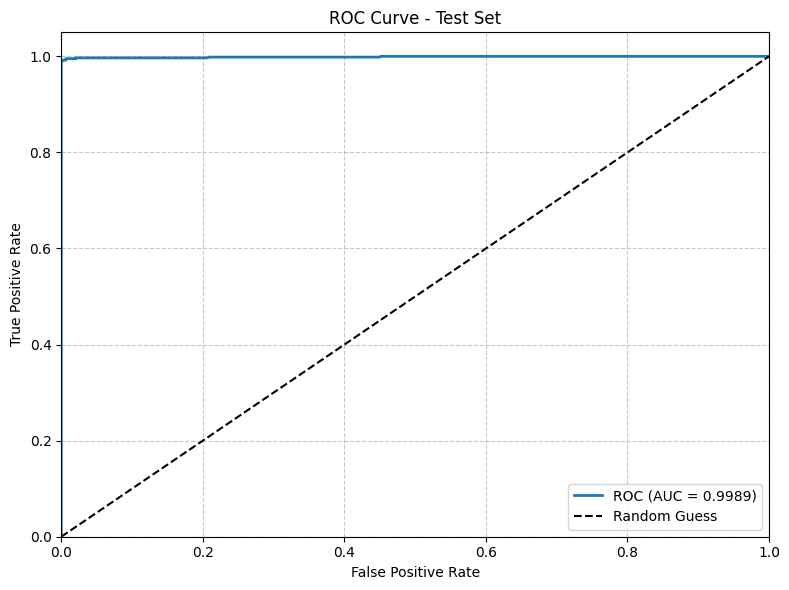

In [2]:
import pandas as pd
import torch
from torch.utils.data import Dataset
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

############################################
# 1. Load Test Data                        #
############################################

test_df = pd.read_csv('/content/test_preprocessed10knew.csv')

# Load XLM-R tokenizer with SentencePiece explicitly enabled
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-large', use_fast=False)

############################################
# 2. Dataset Class                         #
############################################

class ReviewDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts.tolist()  # Ensure it's a list
        self.labels = labels.tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        encodings = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {
            'input_ids': encodings['input_ids'].squeeze(),
            'attention_mask': encodings['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Fix dataset reference
test_dataset = ReviewDataset(test_df['review'], test_df['label'], tokenizer)

############################################
# 3. Compute Metrics & Plotting Functions  #
############################################

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits_tensor = torch.tensor(logits)
    predictions = torch.argmax(logits_tensor, dim=1).numpy()
    probs = torch.nn.functional.softmax(logits_tensor, dim=1)[:, 1].detach().numpy()

    # Compute metrics
    precision, _, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    roc_auc = roc_auc_score(labels, probs)

    return {
        "precision": precision,
        "f1": f1,
        "roc_auc": roc_auc
    }

def plot_roc_curve(labels, probs, title):
    fpr, tpr, _ = roc_curve(labels, probs)
    auc_score = roc_auc_score(labels, probs)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC (AUC = {auc_score:.4f})", linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

############################################
# 4. Load Trained (Best) Model             #
############################################

best_model_path = "/content/xlm-r_large_results/best_model"
model = XLMRobertaForSequenceClassification.from_pretrained(best_model_path, num_labels=2)

training_args = TrainingArguments(
    output_dir="/content/xlm-r_large_results",
    per_device_eval_batch_size=8,
    logging_dir="/content/logs_xlmr_large"
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics
)

############################################
# 5. Evaluate on Test Set                  #
############################################

test_results = trainer.predict(test_dataset)
metrics = compute_metrics((test_results.predictions, test_results.label_ids))

# Print selected metrics
print(f"Precision: {metrics['precision']:.4f}")
print(f"F1-Score: {metrics['f1']:.4f}")
print(f"ROC-AUC: {metrics['roc_auc']:.4f}")

# Compute probabilities correctly
logits = torch.tensor(test_results.predictions)
probs = torch.nn.functional.softmax(logits, dim=1)[:, 1].detach().numpy()

# Plot ROC curve
plot_roc_curve(test_results.label_ids, probs, "ROC Curve - Test Set")

In [3]:
!zip -r best_model.zip /content/xlm-r_large_results/best_model

  adding: content/xlm-r_large_results/best_model/ (stored 0%)
  adding: content/xlm-r_large_results/best_model/model.safetensors (deflated 22%)
  adding: content/xlm-r_large_results/best_model/training_args.bin (deflated 51%)
  adding: content/xlm-r_large_results/best_model/config.json (deflated 50%)


In [4]:
from google.colab import files
files.download('best_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>